# Unsupervised Learning 1 - Classification
### * K-means & DBSCAN
### * Scikit-Learn을 활용하여 쉽게 사용할 수 있습니다

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, colorConverter, LinearSegmentedColormap
from sklearn.decomposition import PCA, NMF
from sklearn.externals.joblib import Memory

memory = Memory(cachedir="cache")

cm_cycle = ListedColormap(['#0000aa', '#ff5050', '#50ff50', '#9040a0', '#fff000'])
cm3 = ListedColormap(['#0000aa', '#ff2020', '#50ff50'])
cm2 = ListedColormap(['#0000aa', '#ff2020'])

# create a smooth transition from the first to to the second color of cm3
# similar to RdBu but with our red and blue, also not going through white,
# which is really bad for greyscale

cdict = {'red': [(0.0, 0.0, cm2(0)[0]),
                 (1.0, cm2(1)[0], 1.0)],

         'green': [(0.0, 0.0, cm2(0)[1]),
                   (1.0, cm2(1)[1], 1.0)],

         'blue': [(0.0, 0.0, cm2(0)[2]),
                  (1.0, cm2(1)[2], 1.0)]}

ReBl = LinearSegmentedColormap("ReBl", cdict)


def discrete_scatter(x1, x2, y=None, markers=None, s=10, ax=None,
                     labels=None, padding=.2, alpha=1, c=None, markeredgewidth=None):
    """Adaption of matplotlib.pyplot.scatter to plot classes or clusters.
    Parameters
    ----------
    x1 : nd-array
        input data, first axis
    x2 : nd-array
        input data, second axis
    y : nd-array
        input data, discrete labels
    cmap : colormap
        Colormap to use.
    markers : list of string
        List of markers to use, or None (which defaults to 'o').
    s : int or float
        Size of the marker
    padding : float
        Fraction of the dataset range to use for padding the axes.
    alpha : float
        Alpha value for all points.
    """
    if ax is None:
        ax = plt.gca()

    if y is None:
        y = np.zeros(len(x1))

    unique_y = np.unique(y)

    if markers is None:
        markers = ['o', '^', 'v', 'D', 's', '*', 'p', 'h', 'H', '8', '<', '>'] * 10

    if len(markers) == 1:
        markers = markers * len(unique_y)

    if labels is None:
        labels = unique_y

    # lines in the matplotlib sense, not actual lines
    lines = []

    current_cycler = mpl.rcParams['axes.prop_cycle']

    for i, (yy, cycle) in enumerate(zip(unique_y, current_cycler())):
        mask = y == yy
        # if c is none, use color cycle
        if c is None:
            color = cycle['color']
        elif len(c) > 1:
            color = c[i]
        else:
            color = c
        # use light edge for dark markers
        if np.mean(colorConverter.to_rgb(color)) < .4:
            markeredgecolor = "grey"
        else:
            markeredgecolor = "black"

        lines.append(ax.plot(x1[mask], x2[mask], markers[i], markersize=s,
                             label=labels[i], alpha=alpha, c=color,
                             markeredgewidth=markeredgewidth,
                             markeredgecolor=markeredgecolor)[0])

    if padding != 0:
        pad1 = x1.std() * padding
        pad2 = x2.std() * padding
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        ax.set_xlim(min(x1.min() - pad1, xlim[0]), max(x1.max() + pad1, xlim[1]))
        ax.set_ylim(min(x2.min() - pad2, ylim[0]), max(x2.max() + pad2, ylim[1]))

    return lines

@memory.cache
def pca_faces(X_train, X_test):
    # copy and pasted from nmf. refactor?
    # Build NMF models with 10, 50, 100, 500 components
    # this list will hold the back-transformd test-data
    reduced_images = []
    for n_components in [10, 50, 100, 500]:
        # build the NMF model
        pca = PCA(n_components=n_components)
        pca.fit(X_train)
        # transform the test data (afterwards has n_components many dimensions)
        X_test_pca = pca.transform(X_test)
        # back-transform the transformed test-data
        # (afterwards it's in the original space again)
        X_test_back = pca.inverse_transform(X_test_pca)
        reduced_images.append(X_test_back)
    return reduced_images


def plot_pca_faces(X_train, X_test, image_shape):
    reduced_images = pca_faces(X_train, X_test)

    # plot the first three images in the test set:
    fix, axes = plt.subplots(3, 5, figsize=(15, 12),
                             subplot_kw={'xticks': (), 'yticks': ()})
    for i, ax in enumerate(axes):
        # plot original image
        ax[0].imshow(X_test[i].reshape(image_shape),
                     vmin=0, vmax=1)
        # plot the four back-transformed images
        for a, X_test_back in zip(ax[1:], reduced_images):
            a.imshow(X_test_back[i].reshape(image_shape), vmin=0, vmax=1)

    # label the top row
    axes[0, 0].set_title("Original")
    for ax, n_components in zip(axes[0, 1:], [10, 50, 100, 500, 2000]):
        ax.set_title("Component = %d" % n_components)


def nmf_faces(X_train, X_test):
    # Build NMF models with 10, 50, 100 and 500 components
    # this list will hold the back-transformd test-data
    reduced_images = []
    for n_components in [10, 50, 100, 500]:
        # build the NMF model
        nmf = NMF(n_components=n_components, random_state=0)
        nmf.fit(X_train)
        # transform the test data (afterwards has n_components many dimensions)
        X_test_nmf = nmf.transform(X_test)
        # back-transform the transformed test-data
        # (afterwards it's in the original space again)
        X_test_back = np.dot(X_test_nmf, nmf.components_)
        reduced_images.append(X_test_back)
    return reduced_images


def plot_nmf_faces(X_train, X_test, image_shape):
    reduced_images = nmf_faces(X_train, X_test)

    # plot the first three images in the test set:
    fix, axes = plt.subplots(3, 5, figsize=(15, 12),
                             subplot_kw={'xticks': (), 'yticks': ()})
    for i, ax in enumerate(axes):
        # plot original image
        ax[0].imshow(X_test[i].reshape(image_shape),
                     vmin=0, vmax=1)
        # plot the four back-transformed images
        for a, X_test_back in zip(ax[1:], reduced_images):
            a.imshow(X_test_back[i].reshape(image_shape), vmin=0, vmax=1)

    # label the top row
    axes[0, 0].set_title("Original")
    for ax, n_components in zip(axes[0, 1:], [10, 50, 100, 500]):
        ax.set_title("Component = %d" % n_components)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: The 'cachedir' parameter has been deprecated in version 0.12 and will be removed in version 0.14.
You provided "cachedir='cache'", use "location='cache'" instead.
  


# 1. Kmeans Classification without Scikit-Learn

In [0]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt

# notebook을 실행한 브라우저에서 바로 그림을 볼 수 있게 해주는 것
%matplotlib inline 

## (1) 데이터 준비

In [0]:
# 인위적으로 2차원 데이터를 생성합니다
X, y = make_blobs(random_state=1)

print(len(X), len(y))
print(X[:10], y[:10])

### X, y를 그림으로 나타내면 다음과 같습니다.

In [0]:
#for visulalization
ax = plt.gca()
ax.set_title("Input data")
ax.plot(X[:,0], X[:,1], 'o')

ax.set_xlim(X[:,0].min() - X[:,0].std(), X[:,0].max() + X[:,0].std())
ax.set_ylim(X[:,1].min() - X[:,1].std(), X[:,1].max() + X[:,1].std())

## (2) K-means Algorithm

### 1) 데이터의 어떤 영역을 대표하는 클러스터 중심(cluster center)을 정한다.

In [0]:
center = X[:3, :] #클러스터 중심을 입력 데이터의 점으로 선택합니다.

#for visulalization
ax = plt.gca()
ax.set_title("Initialize")
ax.plot(X[:,0], X[:,1], 'o')

ax.plot(center[0,0], center[0,1],'r^', markeredgewidth=1, markeredgecolor='k')
ax.plot(center[1,0], center[1,1],'m^', markeredgewidth=1, markeredgecolor='k')
ax.plot(center[2,0], center[2,1],'y^', markeredgewidth=1, markeredgecolor='k')

### 2) 데이터를 가장 가까운 클러스터 중심에 할당한다.

In [0]:
labels = np.argmin(pairwise_distances(center, X), axis=0)
print(labels)

#for visulalization
X_labels = []
for i in range(3):
    X_labels.append([])
    for x, label in zip(X, labels):
        if label == i: X_labels[i].append(x)
    X_labels[i] = np.asarray(X_labels[i])
X_labels = np.asarray(X_labels)
ax = plt.gca()
ax.set_title("point assign(1)")
ax.plot(X_labels[0][:,0], X_labels[0][:,1],'ro')
ax.plot(X_labels[1][:,0], X_labels[1][:,1],'mo')
ax.plot(X_labels[2][:,0], X_labels[2][:,1],'yo')
ax.plot(center[0,0], center[0,1],'r^', markeredgewidth=1, markeredgecolor='k')
ax.plot(center[1,0], center[1,1],'m^', markeredgewidth=1, markeredgecolor='k')
ax.plot(center[2,0], center[2,1],'y^', markeredgewidth=1, markeredgecolor='k')

### 3) 할당된 데이터 포인트의 평균으로 클러스터 중심을 다시 정한다.

In [0]:
center = [X[np.where(labels == i)].mean(axis=0) for i in range(3)]
# 풀어쓰면 다음과 같습니다.
for i in range(3):
    indices = np.where(labels==i)
    center[i] = X[indices].mean(axis=0)

center = np.array(center)
print(center)

#for visulalization
ax = plt.gca()
ax.set_title("calculate the center(1)")
ax.plot(X_labels[0][:,0], X_labels[0][:,1],'ro')
ax.plot(X_labels[1][:,0], X_labels[1][:,1],'mo')
ax.plot(X_labels[2][:,0], X_labels[2][:,1],'yo')
ax.plot(center[0,0], center[0,1],'r^', markeredgewidth=1, markeredgecolor='k')
ax.plot(center[1,0], center[1,1],'m^', markeredgewidth=1, markeredgecolor='k')
ax.plot(center[2,0], center[2,1],'y^', markeredgewidth=1, markeredgecolor='k')

### 4) 2), 3)의 과정(데이터 할당, 클러스터 중심 계산)을 반복한다.

In [0]:
labels = np.argmin(pairwise_distances(center, X), axis=0)
print(labels)

#for visulalization
X_labels = []
for i in range(3):
    X_labels.append([])
    for x, label in zip(X, labels):
        if label == i: X_labels[i].append(x)
    X_labels[i] = np.asarray(X_labels[i])
X_labels = np.asarray(X_labels)
ax = plt.gca()
ax.set_title("point assign(2)")
ax.plot(X_labels[0][:,0], X_labels[0][:,1],'ro')
ax.plot(X_labels[1][:,0], X_labels[1][:,1],'mo')
ax.plot(X_labels[2][:,0], X_labels[2][:,1],'yo')
ax.plot(center[0,0], center[0,1],'r^', markeredgewidth=1, markeredgecolor='k')
ax.plot(center[1,0], center[1,1],'m^', markeredgewidth=1, markeredgecolor='k')
ax.plot(center[2,0], center[2,1],'y^', markeredgewidth=1, markeredgecolor='k')

In [0]:
center = np.array([np.mean(x, axis=0) for x in X_labels])
print(center)

#for visulalization
ax = plt.gca()
ax.set_title("calculate the center(2)")
ax.plot(X_labels[0][:,0], X_labels[0][:,1],'ro')
ax.plot(X_labels[1][:,0], X_labels[1][:,1],'mo')
ax.plot(X_labels[2][:,0], X_labels[2][:,1],'yo')
ax.plot(center[0,0], center[0,1],'r^', markeredgewidth=1, markeredgecolor='k')
ax.plot(center[1,0], center[1,1],'m^', markeredgewidth=1, markeredgecolor='k')
ax.plot(center[2,0], center[2,1],'y^', markeredgewidth=1, markeredgecolor='k')

In [0]:
labels = np.argmin(pairwise_distances(center, X), axis=0)
print(labels)


#for visulalization
X_labels = []
for i in range(3):
    X_labels.append([])
    for x, label in zip(X, labels):
        if label == i: X_labels[i].append(x)
    X_labels[i] = np.asarray(X_labels[i])
X_labels = np.asarray(X_labels)
ax = plt.gca()
ax.set_title("point assign(3)")
ax.plot(X_labels[0][:,0], X_labels[0][:,1],'ro')
ax.plot(X_labels[1][:,0], X_labels[1][:,1],'mo')
ax.plot(X_labels[2][:,0], X_labels[2][:,1],'yo')
ax.plot(center[0,0], center[0,1],'r^', markeredgewidth=1, markeredgecolor='k')
ax.plot(center[1,0], center[1,1],'m^', markeredgewidth=1, markeredgecolor='k')
ax.plot(center[2,0], center[2,1],'y^', markeredgewidth=1, markeredgecolor='k')

In [0]:
center = np.array([np.mean(x, axis=0) for x in X_labels])
print(center)

#for visulalization
ax = plt.gca()
ax.set_title("calculate the center(3)")
ax.plot(X_labels[0][:,0], X_labels[0][:,1],'ro')
ax.plot(X_labels[1][:,0], X_labels[1][:,1],'mo')
ax.plot(X_labels[2][:,0], X_labels[2][:,1],'yo')
ax.plot(center[0,0], center[0,1],'r^', markeredgewidth=1, markeredgecolor='k')
ax.plot(center[1,0], center[1,1],'m^', markeredgewidth=1, markeredgecolor='k')
ax.plot(center[2,0], center[2,1],'y^', markeredgewidth=1, markeredgecolor='k')

In [0]:
labels = np.argmin(pairwise_distances(center, X), axis=0)
print(labels)


#for visulalization
X_labels = []
for i in range(3):
    X_labels.append([])
    for x, label in zip(X, labels):
        if label == i: X_labels[i].append(x)
    X_labels[i] = np.asarray(X_labels[i])
X_labels = np.asarray(X_labels)
ax = plt.gca()
ax.set_title("point assign(4)")
ax.plot(X_labels[0][:,0], X_labels[0][:,1],'ro')
ax.plot(X_labels[1][:,0], X_labels[1][:,1],'mo')
ax.plot(X_labels[2][:,0], X_labels[2][:,1],'yo')
ax.plot(center[0,0], center[0,1],'r^', markeredgewidth=1, markeredgecolor='k')
ax.plot(center[1,0], center[1,1],'m^', markeredgewidth=1, markeredgecolor='k')
ax.plot(center[2,0], center[2,1],'y^', markeredgewidth=1, markeredgecolor='k')

# 2. Kmeans Classification with Scikit-Learn

In [0]:
from sklearn.cluster import KMeans

## (1) 데이터 준비

In [0]:
# 인위적으로 2차원 데이터를 생성합니다
X, y = make_blobs(random_state=1)

## (2) K-Means 알고리즘 실행

In [5]:
# 군집 모델을 만듭니다
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

## (3) 실행결과 확인

In [6]:
print(kmeans.labels_)
print(kmeans.cluster_centers_)

[1 2 2 2 0 0 0 2 1 1 2 2 0 1 0 0 0 1 2 2 0 2 0 1 2 0 0 1 1 0 1 1 0 1 2 0 2
 2 2 0 0 2 1 2 2 0 1 1 1 1 2 0 0 0 1 0 2 2 1 1 2 0 0 2 2 0 1 0 1 2 2 2 0 1
 1 2 0 0 1 2 1 2 2 0 1 1 1 1 2 1 0 1 1 2 2 0 0 1 0 1]
[[ -6.58196786  -8.17239339]
 [ -1.4710815    4.33721882]
 [-10.04935243  -3.85954095]]


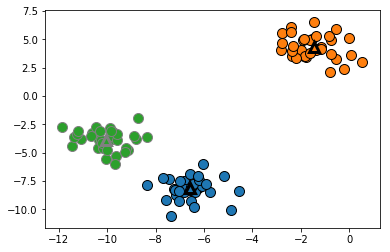

In [7]:
# 데이터를 그래프로 표현하기 위한 함수입니다.
# def discrete_scatter(x1, x2, y=None, markers=None, s=10, ax=None, labels=None, padding=.2, alpha=1, c=None, markeredgewidth=None)
# x1 : input data, first axis
# x2 : input data, sexond axis
# y : input data, discrete labels

discrete_scatter(X[:,0],X[:,1], kmeans.labels_, markers='o')
discrete_scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1],[0,1,2], markers='^', markeredgewidth=3)

## (4) 실습

### 위의 예시를 참고해서, X, y를 적절히 분류해보세요

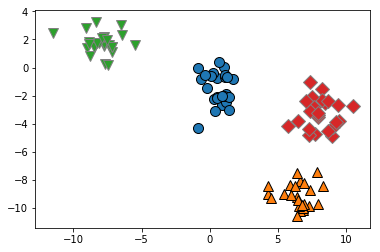

In [10]:
X, y = make_blobs(centers=4, random_state=6)

labels = np.zeros(len(X))
#-----------------------------------------------------
# 이 곳에 코드를 작성하세요.

kmeans = KMeans(n_clusters=4)
kmeans.fit(X)

labels = kmeans.labels_


#-----------------------------------------------------
discrete_scatter(X[:,0],X[:,1], labels)

# 3. DBSCAN with Scikit-Learn

In [0]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.cluster import DBSCAN

## (1) 데이터 준비

In [0]:
# 인위적으로 2차원 데이터를 생성합니다
X, y = make_blobs(random_state=1)

## (2) DBSCAN 알고리즘 실행

In [13]:
dbscan = DBSCAN()
dbscan.fit(X)

DBSCAN(algorithm='auto', eps=0.5, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=5, n_jobs=None, p=None)

## (3) 실행결과 확인

In [14]:
print(dbscan.labels_)

[-1 -1 -1  0 -1  1  1 -1 -1  2 -1  0  1 -1 -1  1  1  2  3 -1  1  3  1  2
  3 -1  1  2 -1 -1  4  5 -1  2 -1  1 -1 -1  3  1  1 -1  2 -1  0  1 -1 -1
 -1  2  3 -1 -1 -1  4  1 -1 -1  4  2  0 -1 -1 -1 -1 -1 -1 -1  2  0  0 -1
  1 -1 -1 -1  1  1  2 -1 -1 -1  0 -1  5 -1 -1 -1  0  5  1  2  4 -1 -1 -1
 -1  4 -1 -1]


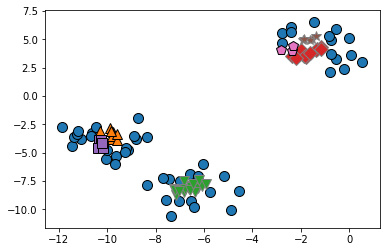

In [15]:
discrete_scatter(X[:,0],X[:,1], dbscan.labels_)

## (4) 실습

### DBSCAN의 파라미터(eps, min_samples)를 조정하여 데이터를 적절히 분류해보세요.
#### ex. dbscan = DBSCAN(eps=0.5, min_samples=5)

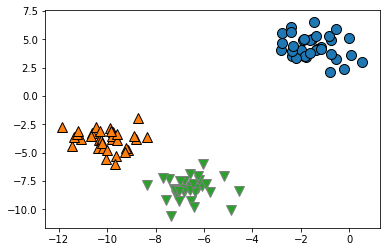

In [23]:
X, y = make_blobs(random_state = 1)

labels = np.zeros(len(X))
#-----------------------------------------------------
# 이 곳에 코드를 작성하세요.


dbscan = DBSCAN(eps=2)
dbscan.fit(X)

labels = dbscan.labels_

#-----------------------------------------------------
discrete_scatter(X[:,0],X[:,1], labels)

### DBSCAN의 파라미터(eps, min_samples)를 조정하여 데이터를 적절히 분류해보세요.
#### ex. dbscan = DBSCAN(eps=0.5, min_samples=5)

[0 0 1 1 1 1 0 1 0 0 1 1 1 1 0 1 0 0 0 0 1 1 0 1 0 0 1 1 1 1 1 0 0 0 0 1 1
 1 0 1 0 0 0 0 0 0 0 1 1 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 0 1 1 0 0 1 0 0 0 0
 0 1 0 0 1 0 1 0 1 1 1 0 1 0 1 0 1 1 1 1 0 1 1 1 0 1]


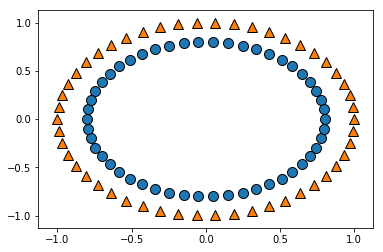

In [34]:
from sklearn.datasets import make_circles
X, y = make_circles()

labels = np.zeros(len(X))
#-----------------------------------------------------
# 이 곳에 코드를 작성하세요.


dbscan = DBSCAN(eps=0.15, min_samples=2)
dbscan.fit(X)

labels = dbscan.labels_
print(labels)


#-----------------------------------------------------
discrete_scatter(X[:,0],X[:,1], labels)

# Unsupervised Learning 2 - Dimensionality Reduction
### * PCA & NMF
### * Scikit-Learn을 활용하여 쉽게 사용할 수 있습니다

## (1) 데이터 준비

In [35]:
from sklearn.datasets import fetch_lfw_people

lfw_people = fetch_lfw_people(min_faces_per_person=20, resize=0.7)

In [36]:
print(lfw_people.data.shape) 
print(lfw_people.images.shape) 
print(lfw_people.target.shape)
print(len(lfw_people.target_names))

(3023, 5655)
(3023, 87, 65)
(3023,)
62


In [37]:
import numpy as np
lfw_counts = np.bincount(lfw_people.target) # 각 클래스별 빈도 계산
for (name, count) in zip(lfw_people.target_names, lfw_counts):
    print("{0:25} {1:4}".format(name, count)) # (이름, 빈도 수) 출력

Alejandro Toledo            39
Alvaro Uribe                35
Amelie Mauresmo             21
Andre Agassi                36
Angelina Jolie              20
Ariel Sharon                77
Arnold Schwarzenegger       42
Atal Bihari Vajpayee        24
Bill Clinton                29
Carlos Menem                21
Colin Powell               236
David Beckham               31
Donald Rumsfeld            121
George Robertson            22
George W Bush              530
Gerhard Schroeder          109
Gloria Macapagal Arroyo     44
Gray Davis                  26
Guillermo Coria             30
Hamid Karzai                22
Hans Blix                   39
Hugo Chavez                 71
Igor Ivanov                 20
Jack Straw                  28
Jacques Chirac              52
Jean Chretien               55
Jennifer Aniston            21
Jennifer Capriati           42
Jennifer Lopez              21
Jeremy Greenstock           24
Jiang Zemin                 20
John Ashcroft               53
John Neg

In [38]:
mask = np.zeros(lfw_people.target.shape, dtype=np.bool)
for target in np.unique(lfw_people.target):
    mask[np.where(lfw_people.target==target)[0][:50]] = True

X_people = lfw_people.data[mask]
y_people = lfw_people.target[mask]
X_people = X_people/255	 # 픽셀 크기를 0~1 사이로 조정
print(X_people.shape) # output = (2063, 5655)
print(y_people.shape) # output = (2063,)

(2063, 5655)
(2063,)


In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_people, y_people, stratify=y_people, random_state=0)

## (2) PCA 알고리즘 실행

In [41]:
from sklearn.decomposition import PCA
pca=PCA(n_components=100, whiten=True, random_state=0).fit(X_train)
X_train_pca = pca.transform(X_train) # X_train에 차원축소 방법인 PCA 적용 
X_test_pca = pca.transform(X_test) # X_test에 차원축소 방법인 PCA 적용 
print(X_train_pca.shape)
print(X_test_pca.shape)
X_train_back = pca.inverse_transform(X_train_pca) # X_train_pca를 원래 데이터로 복구 
X_test_back = pca.inverse_transform(X_test_pca) # X_test_pca를 원래 데이터로 복구 
print(X_train_back.shape)
print(X_test_back.shape)

(1547, 100)
(516, 100)
(1547, 5655)
(516, 5655)


## (3) 실행결과 확인

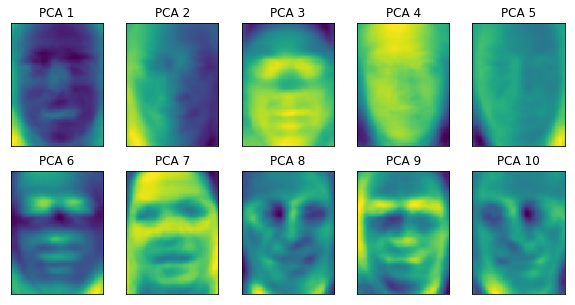

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 5, figsize=(10, 5), 	subplot_kw={'xticks':(), 'yticks':()})

image_shape = lfw_people.images[0].shape	 # output = (87, 65)

for i, (component, ax) in enumerate(zip(pca.components_,axes.ravel())):
    ax.imshow(component.reshape(image_shape))
    ax.set_title("PCA {}".format((i+1)))

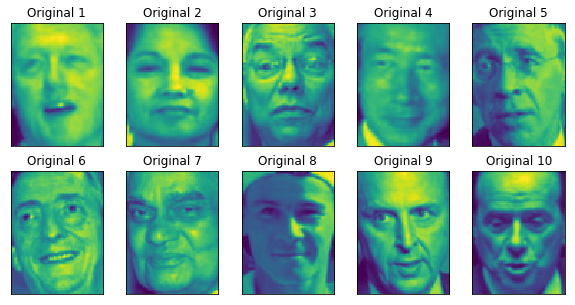

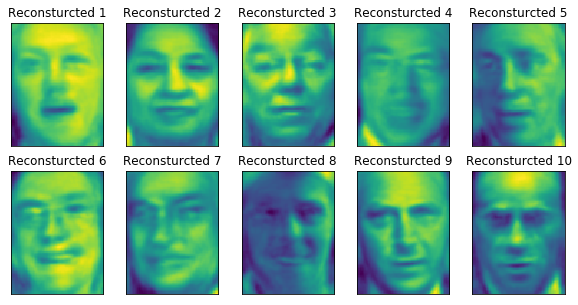

In [43]:
fig, axes = plt.subplots(2, 5, figsize=(10, 5), 	subplot_kw={'xticks':(), 'yticks':()})
for i, (component, ax) in enumerate(zip(X_train,axes.ravel())):
    ax.imshow(component.reshape(image_shape))
    ax.set_title("Original {}".format((i+1)))

fig, axes = plt.subplots(2, 5, figsize=(10, 5), 	subplot_kw={'xticks':(), 'yticks':()})
for i, (component, ax) in enumerate(zip(X_train_back,axes.ravel())):
    ax.imshow(component.reshape(image_shape))
    ax.set_title("Reconsturcted {}".format((i+1)))

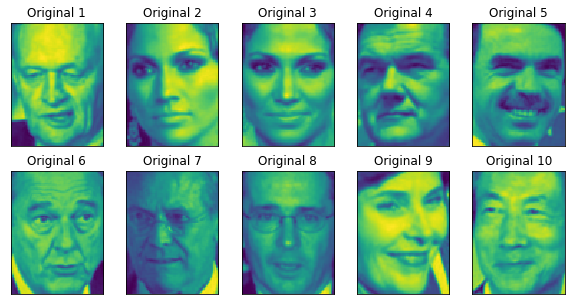

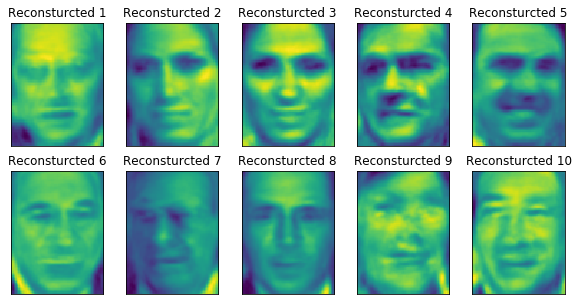

In [44]:
fig, axes = plt.subplots(2, 5, figsize=(10, 5), 	subplot_kw={'xticks':(), 'yticks':()})
for i, (component, ax) in enumerate(zip(X_test,axes.ravel())):
    ax.imshow(component.reshape(image_shape))
    ax.set_title("Original {}".format((i+1)))

fig, axes = plt.subplots(2, 5, figsize=(10, 5), 	subplot_kw={'xticks':(), 'yticks':()})
for i, (component, ax) in enumerate(zip(X_test_back,axes.ravel())):
    ax.imshow(component.reshape(image_shape))
    ax.set_title("Reconsturcted {}".format((i+1)))

________________________________________________________________________________
[Memory] Calling __main__--content-__ipython-input__.pca_faces...
pca_faces(array([[0.535948, ..., 0.243137],
       ...,
       [0.043137, ..., 0.596078]], dtype=float32), 
array([[0.237908, ..., 0.269281],
       ...,
       [0.4     , ..., 0.254902]], dtype=float32))
________________________________________________________pca_faces - 4.3s, 0.1min


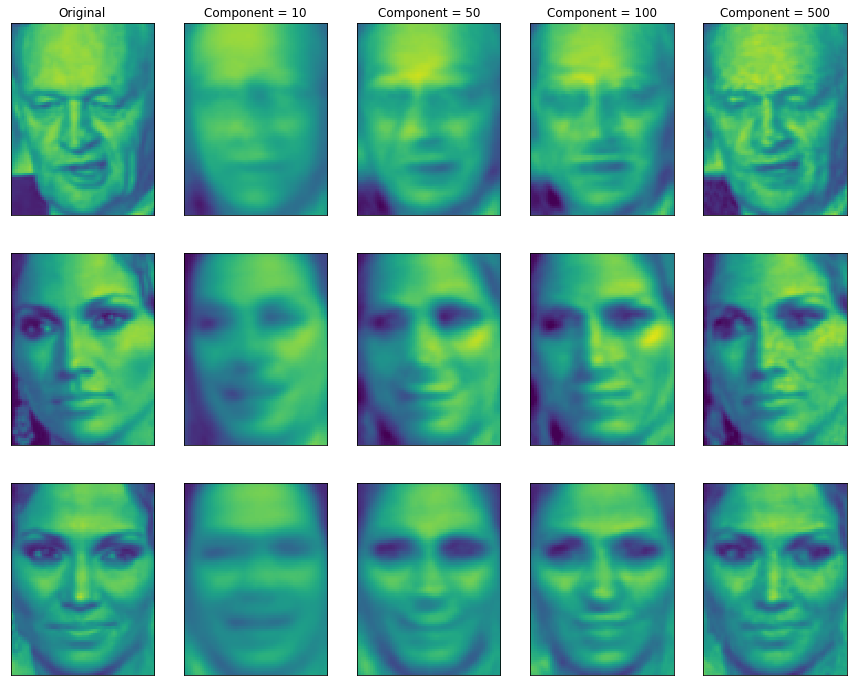

In [45]:
plot_pca_faces(X_train, X_test, image_shape)

## (2) NMF 알고리즘 실행

In [46]:
from sklearn.decomposition import NMF
nmf=NMF(n_components=100, random_state=0).fit(X_train)
X_train_nmf = nmf.transform(X_train) # X_train에 차원축소 방법인 NMF 적용 
X_test_nmf = nmf.transform(X_test) # X_test에 차원축소 방법인 NMF 적용 
print(X_train_nmf.shape)
print(X_test_nmf.shape)
X_train_back = nmf.inverse_transform(X_train_nmf) # X_train_nmf를 원래 데이터로 복구 
X_test_back = nmf.inverse_transform(X_test_nmf) # X_test_nmf를 원래 데이터로 복구 
print(X_train_back.shape)
print(X_test_back.shape)

(1547, 100)
(516, 100)
(1547, 5655)
(516, 5655)


## (3) 실행결과 확인

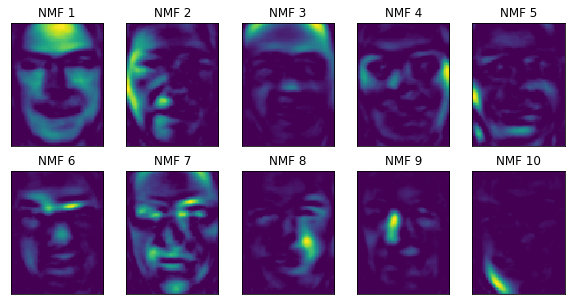

In [49]:
fig, axes = plt.subplots(2, 5, figsize=(10, 5), subplot_kw={'xticks':(), 'yticks':()})

for i, (component, ax) in enumerate(zip(nmf.components_, axes.ravel())):
    ax.imshow(component.reshape(image_shape))
    ax.set_title("NMF {}".format((i+1)))

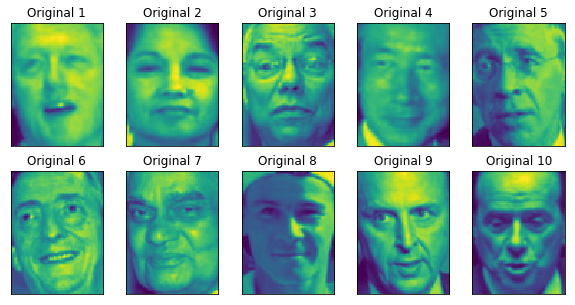

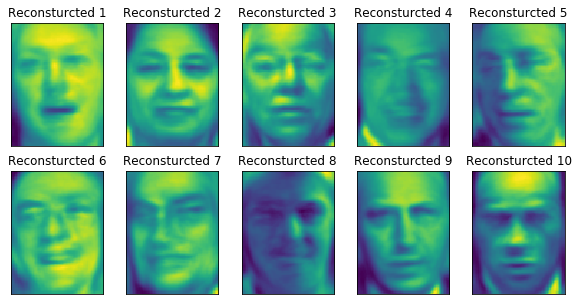

In [50]:
fig, axes = plt.subplots(2, 5, figsize=(10, 5), 	subplot_kw={'xticks':(), 'yticks':()})
for i, (component, ax) in enumerate(zip(X_train,axes.ravel())):
    ax.imshow(component.reshape(image_shape))
    ax.set_title("Original {}".format((i+1)))

fig, axes = plt.subplots(2, 5, figsize=(10, 5), 	subplot_kw={'xticks':(), 'yticks':()})
for i, (component, ax) in enumerate(zip(X_train_back,axes.ravel())):
    ax.imshow(component.reshape(image_shape))
    ax.set_title("Reconsturcted {}".format((i+1)))

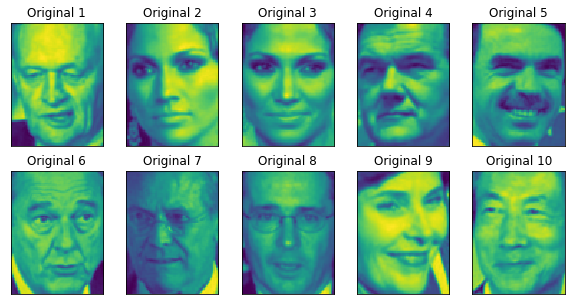

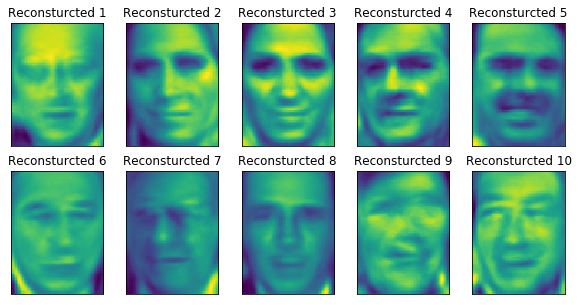

In [51]:
fig, axes = plt.subplots(2, 5, figsize=(10, 5), 	subplot_kw={'xticks':(), 'yticks':()})
for i, (component, ax) in enumerate(zip(X_test,axes.ravel())):
    ax.imshow(component.reshape(image_shape))
    ax.set_title("Original {}".format((i+1)))

fig, axes = plt.subplots(2, 5, figsize=(10, 5), 	subplot_kw={'xticks':(), 'yticks':()})
for i, (component, ax) in enumerate(zip(X_test_back,axes.ravel())):
    ax.imshow(component.reshape(image_shape))
    ax.set_title("Reconsturcted {}".format((i+1)))

In [48]:

plot_nmf_faces(X_train, X_test, image_shape) # time: 8.8min

KeyboardInterrupt: ignored

## 종합

Text(0, 0.5, 'NMF')

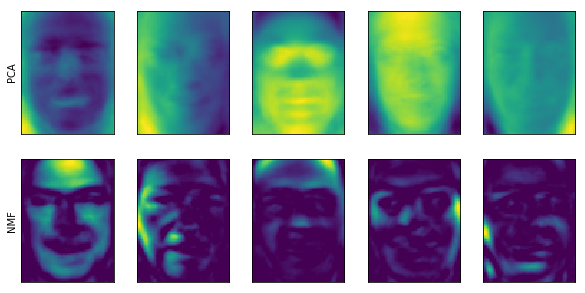

In [52]:
fig, axes = plt.subplots(2, 5, figsize=(10, 5), subplot_kw={'xticks': (), 'yticks':()})
for ax, fe_pca, fe_nmf in zip(axes.T, pca.components_, nmf.components_):
    ax[0].imshow(fe_pca.reshape(image_shape))
    ax[1].imshow(fe_nmf.reshape(image_shape))

axes[0,0].set_ylabel("PCA")
axes[1,0].set_ylabel("NMF")

Text(0, 0.5, 'NMF')

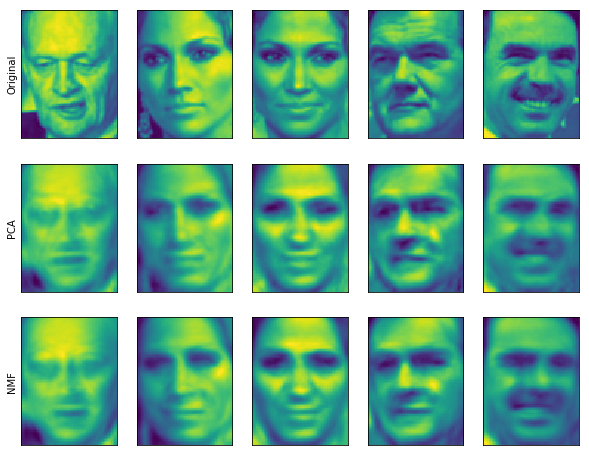

In [53]:
X_reconstructed_pca=pca.inverse_transform(pca.transform(X_test))
X_reconstructed_nmf=np.dot(nmf.transform(X_test), nmf.components_)
fig, axes=plt.subplots(3, 5, figsize=(10, 8), subplot_kw={'xticks': (),'yticks':()})
for ax, ori, ir_pca, ir_nmf in zip(axes.T, X_test, X_reconstructed_pca,X_reconstructed_nmf):
    ax[0].imshow(ori.reshape(image_shape))
    ax[1].imshow(ir_pca.reshape(image_shape))
    ax[2].imshow(ir_nmf.reshape(image_shape))

axes[0,0].set_ylabel("Original")
axes[1,0].set_ylabel("PCA")
axes[2,0].set_ylabel("NMF")

# TensorFlow Tutorial

In [0]:
import tensorflow as tf

## Data Flow Graphs

In [55]:
a = tf.add(3, 5)
print(a)

Tensor("Add:0", shape=(), dtype=int32)


In [56]:
sess = tf.Session()
print(sess.run(a))    # 8
sess.close()  # 더 이상 필요하지 않은 자원을 할당 해제

8


In [57]:
with tf.Session() as sess:
    print(sess.run(a))    # 8

8


## Constants & Operations

In [58]:
a = tf.constant([2, 2])
b = tf.constant([[0, 1], [2, 3]])
x = tf.add(a, b)
y = tf.multiply(a, b)
with tf.Session() as sess:
    x, y = sess.run([x, y])
    print(x)
    print(y)

[[2 3]
 [4 5]]
[[0 2]
 [4 6]]


## 실습

### 텐서플로우의 상수와 오퍼레이션을 이용하여 우변의 값을 얻어보자
![tf_eq](https://github.com/jin530/190428_unsupervised_tensorflow/blob/master/image/tf_equation.png?raw=1)

In [65]:
val1 = np.zeros(3)
val2 = np.zeros(1)
val3 = np.zeros((2,2))
#-----------------------------------------------------
# 이 곳에 코드를 작성하세요.

a1 = tf.constant([1,2,3])
b1 = tf.constant([4,5,6])
c1 = a1*b1


a2 = tf.constant([3,3])
b2 = tf.reshape(a2,[2,1])
c2 = tf.matmul(tf.reshape(a2,[1,2]),b2)

c3 = tf.matmul(b2, tf.reshape(a2,[1,2]))

with tf.Session() as sess:
  val1, val2, val3 = sess.run([c1, c2, c3])





#-----------------------------------------------------
print(val1)
print(val2)
print(val3)

[ 4 10 18]
[[18]]
[[9 9]
 [9 9]]


## Variables

In [66]:
W = tf.Variable(10)
assign_op = W.assign(100)
with tf.Session() as sess:
    sess.run(assign_op)
    print(W.eval())

Instructions for updating:
Colocations handled automatically by placer.
100


## 실습

### 텐서플로우의 변수와 오퍼레이션을 이용하여 우변의 값을 얻어보자
![tf_eq](https://github.com/jin530/190428_unsupervised_tensorflow/blob/master/image/tf_equation.png?raw=1)

In [76]:
val1 = np.zeros(3)
val2 = np.zeros(1)
val3 = np.zeros((2,2))
#-----------------------------------------------------
# 이 곳에 코드를 작성하세요.

a1 = tf.placeholder(tf.int64)
b1 = tf.placeholder(tf.int64)
c1 = tf.multiply(a1,b1)

a2 = tf.placeholder(tf.int32)
b2 = tf.reshape(a2,[2,1])
c2 = tf.matmul(tf.reshape(a2,[1,2]),b2)

c3 = tf.matmul(b2, tf.reshape(a2,[1,2]))

# init = tf.global_variables_initializer()
with tf.Session() as sess:
#   sess.run(init)
  val1, val2, val3 = sess.run([c1, c2, c3], feed_dict={a1:[1,2,3], b1:[4,5,6], a2:[3,3]})



#-----------------------------------------------------
print(val1)
print(val2)
print(val3)

[ 4 10 18]
[[18]]
[[9 9]
 [9 9]]


## Placeholder

In [71]:
a = tf.placeholder(tf.float32, shape=[3])
b = tf.constant([5, 5, 5], tf.float32)
c = a + b # tf.add(a, b) 와 같다.
with tf.Session() as sess:
    print(sess.run(c, feed_dict={a: [1, 2, 3]}))

[6. 7. 8.]


## 실습

### 텐서플로의 플레이스홀더와 오퍼레이션을 이용하여 우변의 값을 얻어보자
![tf_eq](https://github.com/jin530/190428_unsupervised_tensorflow/blob/master/image/tf_equation.png?raw=1)

In [0]:
val1 = np.zeros(3)
val2 = np.zeros(1)
val3 = np.zeros((2,2))
#-----------------------------------------------------
# 이 곳에 코드를 작성하세요.






#-----------------------------------------------------
print(val1)
print(val2)
print(val3)